# M2177.004300 002 Deep Learning Assignment #1<br> Part 2: Training Convolutional Neural Networks

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Hyungi Kim, September 2024

**For understanding of this work, please carefully look at given PDF file.**

In this notebook, you will learn how to train convolutional neural networks (CNNs) for classifying images in the CIFAR-10 dataset. <br>
There are **3 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results. 

### Some helpful tutorials and references for assignment #1-3:
- [1] Pytorch official documentation. [[link]](https://pytorch.org/docs/stable/index.html)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)

## 1. Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *data* directory. <br>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64,
                                          shuffle=True, num_workers=2)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

(274, 274, 3)


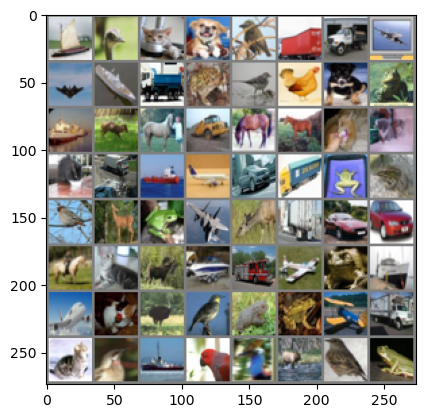

ship bird cat dog bird truck truck plane
torch.Size([3, 32, 32])


In [5]:
# get some random training images
images, labels = next(iter(dataloader_train))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(classes[labels[j]] for j in range(8)))
# print size of single image
print(images[1].shape)

## 2. Training a small CNN model

#### CNN architecture in order:
* 7x7 Convolutional layer with 8 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* 4x4 Convolutional layer with 16 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* Fully connected layer with 100 output units and ReLU activation
* Fully connected layer with 80 output units and ReLU activation
* Fully connected layer with 10 output units 
* You can use any padding option.

#### Training setup:
* Loss function: Softmax cross entropy
* Optimizer: Gradient descent with 0.001 learning rate
* Batch size: 64
* Training epoch: 5

In [6]:
# Define a CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 7, stride = 1, padding = 3)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 4, stride = 1, padding = 2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 100)
        self.fc2 = nn.Linear(100, 80)
        self.fc3 = nn.Linear(80, 10)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return x


In [7]:
# Function to train the network

def train(net, dataloader_train, max_epoch, crit, optimizer, device, model_path='./cifar_net.pt'):

    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader_train, 0):
            # get the inputs; data is a list of [inputs, targets]
            inputs, targets = data
        
            # Training on GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = crit(outputs, targets)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            
            print_every = 100
            if (i + 1) % print_every == 0:    # print every 100 mini-batches
                print(f'[{epoch + 1}, {i + 1}] loss: {(running_loss / print_every):.3f}')
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

In [8]:
# function to calculate accuracy
def test(net, dataloader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Inference on GPU
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    print(f'Accuracy of the network on the {total} test images: {(100 * correct / total):.3f} %')

In [9]:
PATH = './model_checkpoints/cifar_net.pt'
epoch = 5

# initialize model
net = Net()

# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train(net, dataloader_train, epoch, criterion, optimizer, device, PATH)

# load trained model then test
net.load_state_dict(torch.load(PATH))
test(net, dataloader_test, device)

[1, 100] loss: 2.306
[1, 200] loss: 2.304
[1, 300] loss: 2.302
[1, 400] loss: 2.301
[1, 500] loss: 2.299
[1, 600] loss: 2.295
[1, 700] loss: 2.290
[2, 100] loss: 2.265
[2, 200] loss: 2.231
[2, 300] loss: 2.175
[2, 400] loss: 2.113
[2, 500] loss: 2.055
[2, 600] loss: 2.014
[2, 700] loss: 1.981
[3, 100] loss: 1.923
[3, 200] loss: 1.921
[3, 300] loss: 1.856
[3, 400] loss: 1.829
[3, 500] loss: 1.811
[3, 600] loss: 1.781
[3, 700] loss: 1.758
[4, 100] loss: 1.717
[4, 200] loss: 1.665
[4, 300] loss: 1.652
[4, 400] loss: 1.629
[4, 500] loss: 1.611
[4, 600] loss: 1.579
[4, 700] loss: 1.570
[5, 100] loss: 1.536
[5, 200] loss: 1.524
[5, 300] loss: 1.514
[5, 400] loss: 1.495
[5, 500] loss: 1.500
[5, 600] loss: 1.463
[5, 700] loss: 1.482
Finished Training
Saved Trained Model


C:\Users\johng\AppData\Local\Temp\ipykernel_29164\2907232859.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


Accuracy of the network on the 10000 test images: 47.730 %


## <a name="3-1"></a>3-1. Design an Inception module

In this section, you will implement a little more complex CNN model with an `Inception module`. <br>

![Inception_module](imgs/Inception.png)

Using the code provided as guidance, <br>
Define an `inception module`, which is the building block of **Inception model (a.k.a GoogLeNet)**, the winner of ILSVRC14. <br>


#### Inception model architecture:
* CNN model consists with stem layer, inception module, and fully connected layer
* Stem layer with
    * conv-pooling-conv-pooling
* `Inception module` with 
    * 3(or 4) main convolutions (blue blocks in the Figure(a))
    * 3 dimensionality reduction convolutions (yellow blocks in the Figure(a))
    * 3x3 max pooling block (red blocks in the Figure(a))
    * Batch Nomalization and ReLU activation after all conv layer
* Fully connected layer with 10 output units and linear activation
* Choose the proper padding option on your own.

In [10]:
'''
About parameter
in_planes : # of input channel
n1xn1 : # of output channel for first branch
n3xn3_blue : # of output channel for second branch's 1x1 conv layer
n3xn3 : # of output channel for second branch
n5xn5_blue : # of output channel for third branch's 1x1 conv layer
n5xn5 : # of output channel for third branch
pool_planes : # of output channel for fourth branch

'''
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3_blue, n3x3, n5x5_blue, n5x5, pool_planes):
        super(Inception, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU()
        )
        
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3_blue, kernel_size=1),
            nn.BatchNorm2d(n3x3_blue),
            nn.ReLU(),
            nn.Conv2d(n3x3_blue, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU()
        )
        
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5_blue, kernel_size=1),
            nn.BatchNorm2d(n5x5_blue),
            nn.ReLU(),
            nn.Conv2d(n5x5_blue, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU()
        )
        
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU()
        )
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

In [11]:
class InceptionNet(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.MaxPool2d(3, stride=2, padding=1),
        )
        self.inception_blocks = nn.Sequential(
            Inception(192, 64, 96, 128, 16, 32, 32),  # Inception 3a
            Inception(256, 128, 128, 192, 32, 96, 64),  # Inception 3b
            nn.MaxPool2d(3, stride=2, padding=1),  # MaxPool
            Inception(480, 192, 96, 208, 16, 48, 64),  # Inception 4a
            Inception(512, 160, 112, 224, 24, 64, 64),  # Inception 4b
            Inception(512, 128, 128, 256, 24, 64, 64),  # Inception 4c
            Inception(512, 112, 144, 288, 32, 64, 64),  # Inception 4d
            Inception(528, 256, 160, 320, 32, 128, 128),  # Inception 4e
            nn.MaxPool2d(3, stride=2, padding=1),  # MaxPool
            Inception(832, 256, 160, 320, 32, 128, 128),  # Inception 5a
            Inception(832, 384, 192, 384, 48, 128, 128),  # Inception 5b
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(nn.Dropout(0.4), nn.Linear(1024, num_classes))

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception_blocks(x)
        x = self.avgpool(x).view(x.size(0), -1)
        return self.fc(x)

In [12]:
PATH = './model_checkpoints/inception_net.pt'
epoch = 5

# initialize model
inception_net = InceptionNet()
inception_net = inception_net.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(inception_net.parameters(), lr=0.001, momentum=0.9)

# Train
train(inception_net, dataloader_train, epoch, criterion, optimizer, device, PATH)
# Test
inception_net.load_state_dict(torch.load(PATH))
test(inception_net, dataloader_test, device)

[1, 100] loss: 2.168
[1, 200] loss: 1.900
[1, 300] loss: 1.825
[1, 400] loss: 1.714
[1, 500] loss: 1.638
[1, 600] loss: 1.578
[1, 700] loss: 1.522
[2, 100] loss: 1.404
[2, 200] loss: 1.366
[2, 300] loss: 1.318
[2, 400] loss: 1.300
[2, 500] loss: 1.278
[2, 600] loss: 1.276
[2, 700] loss: 1.266
[3, 100] loss: 1.121
[3, 200] loss: 1.105
[3, 300] loss: 1.095
[3, 400] loss: 1.083
[3, 500] loss: 1.070
[3, 600] loss: 1.068
[3, 700] loss: 1.084
[4, 100] loss: 0.927
[4, 200] loss: 0.952
[4, 300] loss: 0.935
[4, 400] loss: 0.962
[4, 500] loss: 0.956
[4, 600] loss: 0.909
[4, 700] loss: 0.934
[5, 100] loss: 0.815
[5, 200] loss: 0.803
[5, 300] loss: 0.822
[5, 400] loss: 0.814
[5, 500] loss: 0.811
[5, 600] loss: 0.832
[5, 700] loss: 0.820
Finished Training
Saved Trained Model


C:\Users\johng\AppData\Local\Temp\ipykernel_29164\117343984.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inception_net.load_state_dict(torch.load(PATH))


Accuracy of the network on the 10000 test images: 67.480 %


## <a name="3-2"></a>3-2. Design an Residual Block module

In this section, you will implement a little more complex CNN model with a `Residual block`. <br>

![Residual_block](imgs/Residualblock.png)

Using the code provided as guidance, <br>
Define a `residual block module`, which is the building block of **Residual neural network (a.k.a ResNet)**, the winner of ILSVRC15. <br>


#### ResNet architecture:
* A residual block consists of convolutional layers, bach normalization, ReLU actication functions, and Shortcut Connection.
* Define the Short Connection which directly connects the input of the block to the output.
* The shortcut module must be sequential layers that contain:
    * 1 convolution of kernel size 1
    * 1 batch normalization layer

In [13]:
# Define the residual block class
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # The first convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # The second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection (identity mapping)
        if stride != 1 or in_channels != out_channels:
            ############################################################################## 
            #                        IMPLEMENT OF YOUR CODE                       #
            ##############################################################################
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

            ############################################################################## 
            #                           END OF YOUR CODE                          #
            ##############################################################################
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x):
        # Pass through the first convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)
        
        # Pass through the second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Shortcut connection
        shortcut = self.shortcut(x)
        
        # Add the output and the shortcut and pass it through a relu activation layer for the final output. (Residual connection implementation)
        ############################################################################## 
            #                        IMPLEMENT OF YOUR CODE                       #
        ##############################################################################
        out += shortcut
        out = nn.ReLU()(out)
        ############################################################################## 
            #                        IMPLEMENT OF YOUR CODE                       #
        ##############################################################################
        return out

In [14]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = [block(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        layers += [block(out_channels, out_channels) for _ in range(1, blocks)]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        return self.fc(torch.flatten(x, 1))

In [15]:
PATH = './model_checkpoints/resnet.pt'
epoch = 5

# initialize model
resnet = ResNet(ResidualBlock, [2, 2, 2, 2], 10)
resnet = resnet.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Train
train(resnet, dataloader_train, epoch, criterion, optimizer, device, PATH)
# Test
resnet.load_state_dict(torch.load(PATH))
test(resnet, dataloader_test, device)

[1, 100] loss: 1.905
[1, 200] loss: 1.574
[1, 300] loss: 1.450
[1, 400] loss: 1.383
[1, 500] loss: 1.328
[1, 600] loss: 1.264
[1, 700] loss: 1.224
[2, 100] loss: 1.071
[2, 200] loss: 1.066
[2, 300] loss: 1.078
[2, 400] loss: 1.034
[2, 500] loss: 1.022
[2, 600] loss: 1.008
[2, 700] loss: 0.989
[3, 100] loss: 0.818
[3, 200] loss: 0.835
[3, 300] loss: 0.820
[3, 400] loss: 0.848
[3, 500] loss: 0.809
[3, 600] loss: 0.839
[3, 700] loss: 0.837
[4, 100] loss: 0.651
[4, 200] loss: 0.670
[4, 300] loss: 0.675
[4, 400] loss: 0.688
[4, 500] loss: 0.702
[4, 600] loss: 0.688
[4, 700] loss: 0.701
[5, 100] loss: 0.517
[5, 200] loss: 0.542
[5, 300] loss: 0.559
[5, 400] loss: 0.568
[5, 500] loss: 0.598
[5, 600] loss: 0.565
[5, 700] loss: 0.588
Finished Training
Saved Trained Model


C:\Users\johng\AppData\Local\Temp\ipykernel_29164\574398188.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load(PATH))


Accuracy of the network on the 10000 test images: 69.260 %


## <a name="3-3"></a>3-3. Design a better model on CIFAR-10

Now it's your job to experiment with CNNs to train a model that achieves **<font color=red>>= 73% accuracy on the test set</font>** of CIFAR-10. <br> You can reuse the implemented functions from above.

### Things you can try to change:
- Filter size
- Number of filters
- Pooling vs Strided Convolution
- Network architectures
- Optimizers
- Activation functions
- Regularizations
- Model ensembles
- Data augmentation
- learning rate scheduler

In [29]:
# Residual Block class with ELU activation function
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.elu(out) # ELU
        out = self.conv2(out)
        out = self.bn2(out)
        shortcut = self.shortcut(x)
        out += shortcut
        out = F.elu(out)
        return out

In [30]:
# Define a CNN model
class BetterNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(BetterNet, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = [block(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        layers += [block(out_channels, out_channels) for _ in range(1, blocks)]
        return nn.Sequential(*layers)

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.elu(out) # ELU
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return out


In [31]:
PATH = './model_checkpoints/better_net.pt'

# initialize model
betternet = BetterNet(ResidualBlock, [2, 2, 2, 2], 10)
betternet = betternet.to(device)

# Hyperparameters
lr = 0.1
batch_size = 128
epoch = 10 # Increased epochs to 10

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(betternet.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Train
train(betternet, dataloader_train, epoch, criterion, optimizer, device, PATH)
# Test
betternet.load_state_dict(torch.load(PATH))
test(betternet, dataloader_test, device)

[1, 100] loss: 3.026
[1, 200] loss: 1.925
[1, 300] loss: 1.812
[1, 400] loss: 1.683
[1, 500] loss: 1.615
[1, 600] loss: 1.579
[1, 700] loss: 1.513
[2, 100] loss: 1.413
[2, 200] loss: 1.399
[2, 300] loss: 1.317
[2, 400] loss: 1.261
[2, 500] loss: 1.243
[2, 600] loss: 1.195
[2, 700] loss: 1.182
[3, 100] loss: 1.079
[3, 200] loss: 1.094
[3, 300] loss: 1.086
[3, 400] loss: 1.063
[3, 500] loss: 1.023
[3, 600] loss: 0.992
[3, 700] loss: 0.969
[4, 100] loss: 0.902
[4, 200] loss: 0.899
[4, 300] loss: 0.903
[4, 400] loss: 0.887
[4, 500] loss: 0.860
[4, 600] loss: 0.843
[4, 700] loss: 0.829
[5, 100] loss: 0.803
[5, 200] loss: 0.740
[5, 300] loss: 0.764
[5, 400] loss: 0.747
[5, 500] loss: 0.752
[5, 600] loss: 0.739
[5, 700] loss: 0.733
[6, 100] loss: 0.660
[6, 200] loss: 0.678
[6, 300] loss: 0.663
[6, 400] loss: 0.680
[6, 500] loss: 0.654
[6, 600] loss: 0.676
[6, 700] loss: 0.657
[7, 100] loss: 0.601
[7, 200] loss: 0.591
[7, 300] loss: 0.604
[7, 400] loss: 0.596
[7, 500] loss: 0.622
[7, 600] loss

C:\Users\johng\AppData\Local\Temp\ipykernel_29164\4060122207.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  betternet.load_state_dict(torch.load(PATH))


Accuracy of the network on the 10000 test images: 80.150 %


### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

You can write in Korean

_Tell us here_

1. I changed the activation function from ReLU to ELU in the residual block module and resnet model. I took inspiration from A. Shah et al (2016) for changing the activation function.

2. I attempted to create more complexity by removing the max pooling layer.

3. I added a learning rate decay to the optimizer, similar to Assignment 1-1. I heard Adam might be better, but several papers said they couldn't detect significant differences in SGD and Adam.

4. I also ran the model for more epochs, as the loss stabilized around epochs 7~9. (This could have been handled better with early stopping)
